# Determining the cost of cars

A service for selling used cars is developing an application to attract new customers. Here you can quickly find out the market value of your car. Based on historical data, it is necessary to build a model to determine the cost of the car.

The following are important to the customer:

- quality of prediction;
- prediction speed;
- studying time.

Target:
Development of a system for recommending the cost of a car based on its description


## Data preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import time

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# data=pd.read_csv('/datasets/autos.csv')

In [5]:
data=pd.read_csv('/content/drive/MyDrive/datasets/autos.csv')

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

In [9]:
# data['RegistrationYear'] = pd.Categorical(data['RegistrationYear'])
# data['RegistrationMonth'] = pd.Categorical(data['RegistrationMonth'])

In [10]:
# Convert all column names to lowercase
data.columns = data.columns.str.lower()

# Checking results
print(data.columns)

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        316879 non-null  object        
 3   registrationyear   354369 non-null  int64         
 4   gearbox            334536 non-null  object        
 5   power              354369 non-null  int64         
 6   model              334664 non-null  object        
 7   kilometer          354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           321474 non-null  object        
 10  brand              354369 non-null  object        
 11  repaired           283215 non-null  object        
 12  datecreated        354369 non-null  datetime64[ns]
 13  numberofpictures   354369 non-null  int64   

In [12]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [13]:
# Identifying obvious duplicates
duplicates = data.duplicated()

# Counting the number of obvious duplicates
num_duplicates = duplicates.sum()
print(f"Number of obvious duplicates in the data: {num_duplicates}")


Number of obvious duplicates in the data: 4


In [14]:
# Remove duplicates if there are any
if num_duplicates > 0:
     data.drop_duplicates(inplace=True)
     print("Duplicates have been removed.")
else:
     print("No duplicates found.")

Duplicates have been removed.


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        316875 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            334532 non-null  object        
 5   power              354365 non-null  int64         
 6   model              334660 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           321470 non-null  object        
 10  brand              354365 non-null  object        
 11  repaired           283211 non-null  object        
 12  datecreated        354365 non-null  datetime64[ns]
 13  numberofpictures   354365 non-null  int64   

In [16]:
# Removing 'DateCrawled', 'DateCreated' and 'LastSeen' columns
data.drop(columns=['datecreated', 'lastseen','numberofpictures'], inplace=True)

In [17]:
data['fueltype'].fillna('other', inplace=True)
data['vehicletype'].fillna('other', inplace=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        354365 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            334532 non-null  object        
 5   power              354365 non-null  int64         
 6   model              334660 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           354365 non-null  object        
 10  brand              354365 non-null  object        
 11  repaired           283211 non-null  object        
 12  postalcode         354365 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
me

In [19]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,postalcode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


In [20]:
data['gearbox'].fillna('unknown', inplace=True)

In [21]:
data['model'].fillna('unknown', inplace=True)

In [22]:
data['repaired'].fillna('unknown', inplace=True)

In [23]:
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,postalcode
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,70435
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,66954
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,90480
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


In [24]:
# Convert 'datecrawled' to datetime format
data['datecrawled'] = pd.to_datetime(data['datecrawled'])

# Determine the maximum and minimum year in 'datecrawled'
max_year_crawled = data['datecrawled'].dt.year.max()


# Data filtering to exclude unrealistic year of registration values
data = data[(data['registrationyear'] >= 1950) & (data['registrationyear'] <= max_year_crawled)]


# Removing cars with unrealistic prices
data = data[(data['price'] > 100) & (data['price'] <= 20000)]

# Removing entries with unrealistic cardinality
data = data[(data['power'] > 10) & (data['power'] <= 500)]


# Checking results
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,postalcode
count,294457.000000,294457.00000,294457.000000,294457.000000,294457.000000,294457.000000
mean,4882.296858,2002.85097,120.744462,128302.689357,6.002992,51246.025508
std,4608.957595,6.48418,53.447029,36695.275368,3.579086,25766.295744
min,101.000000,1950.00000,11.000000,5000.000000,0.000000,1067.000000
25%,1350.000000,1999.00000,77.000000,125000.000000,3.000000,30938.000000
50%,3200.000000,2003.00000,111.000000,150000.000000,6.000000,50259.000000
75%,6999.000000,2007.00000,150.000000,150000.000000,9.000000,72108.000000
max,20000.000000,2016.00000,500.000000,150000.000000,12.000000,99998.000000


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294457 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        294457 non-null  datetime64[ns]
 1   price              294457 non-null  int64         
 2   vehicletype        294457 non-null  object        
 3   registrationyear   294457 non-null  int64         
 4   gearbox            294457 non-null  object        
 5   power              294457 non-null  int64         
 6   model              294457 non-null  object        
 7   kilometer          294457 non-null  int64         
 8   registrationmonth  294457 non-null  int64         
 9   fueltype           294457 non-null  object        
 10  brand              294457 non-null  object        
 11  repaired           294457 non-null  object        
 12  postalcode         294457 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
me

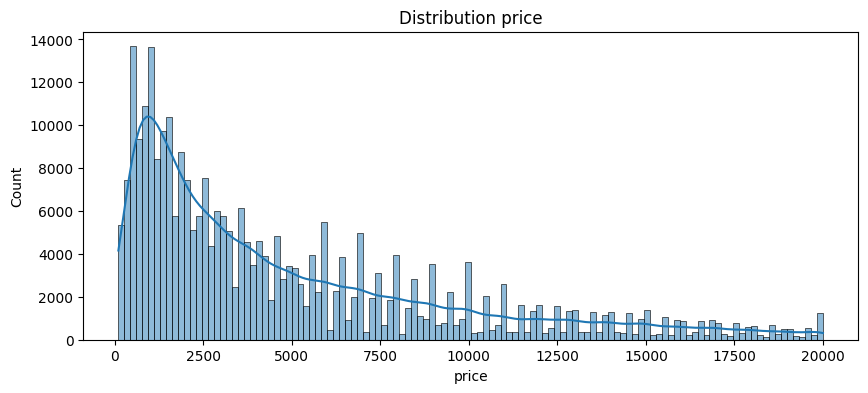

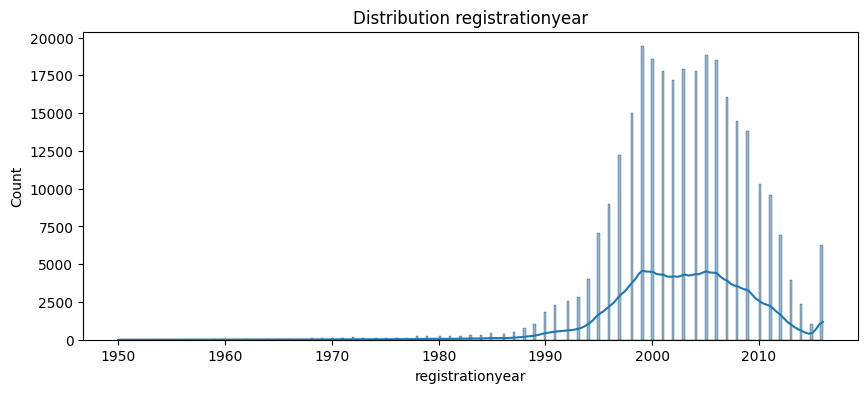

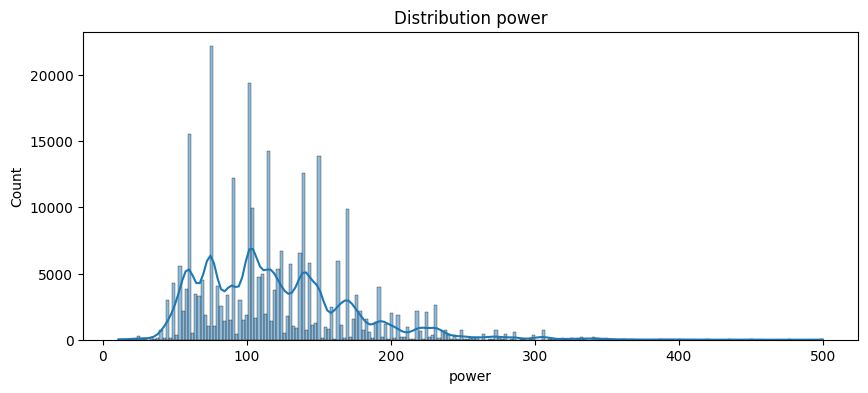

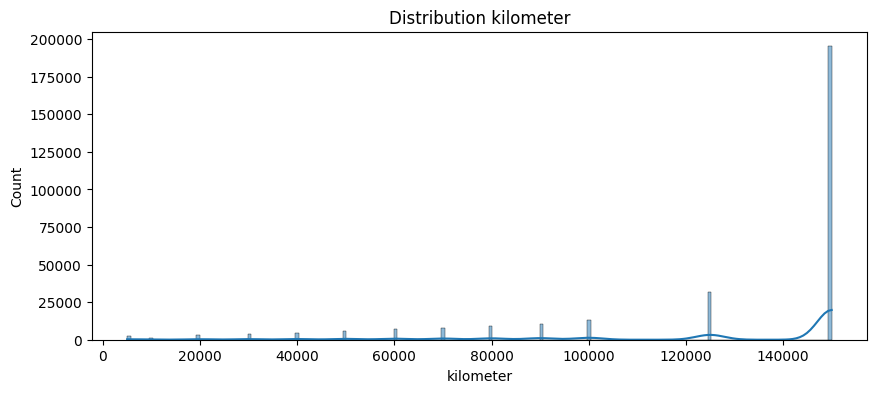

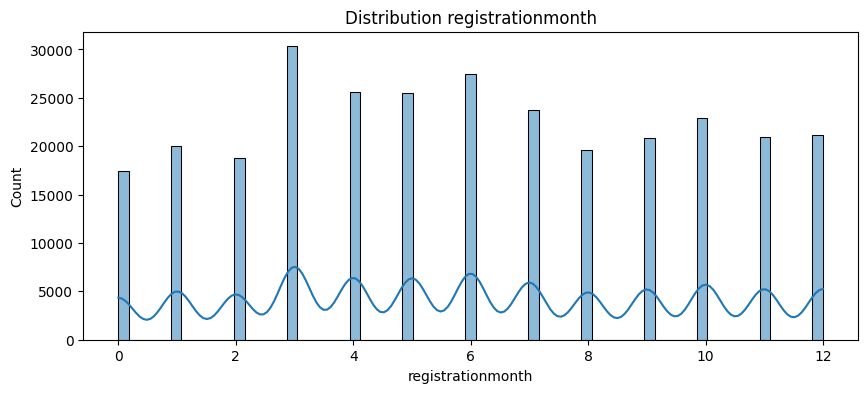

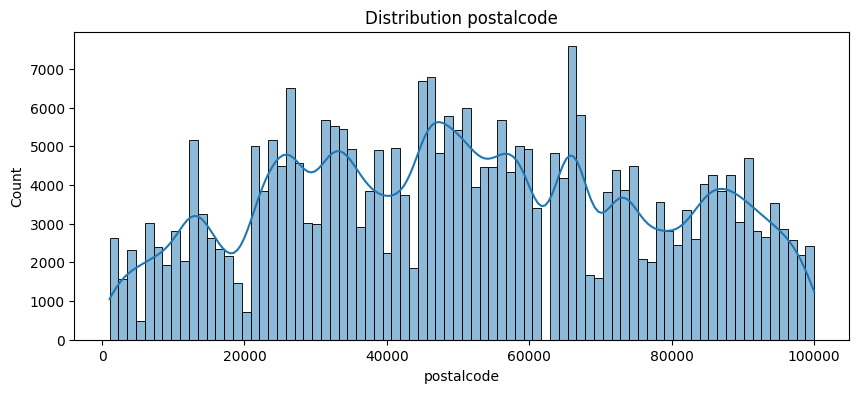

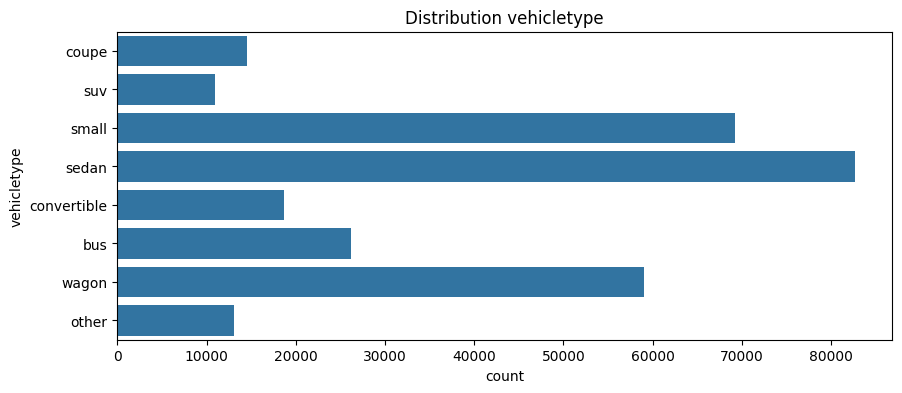

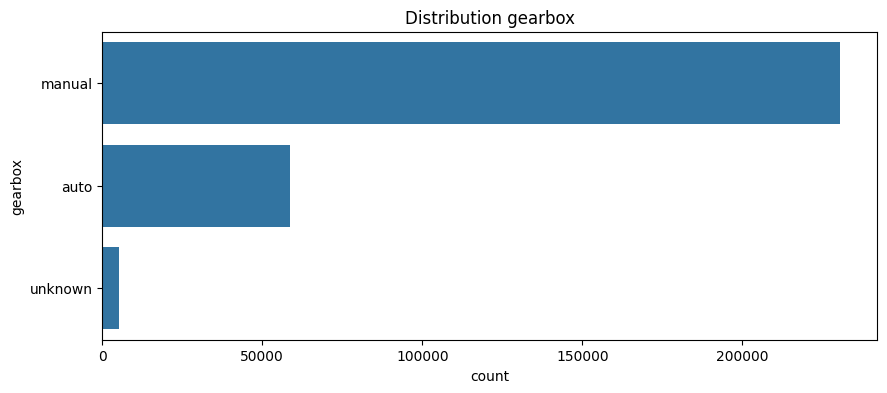

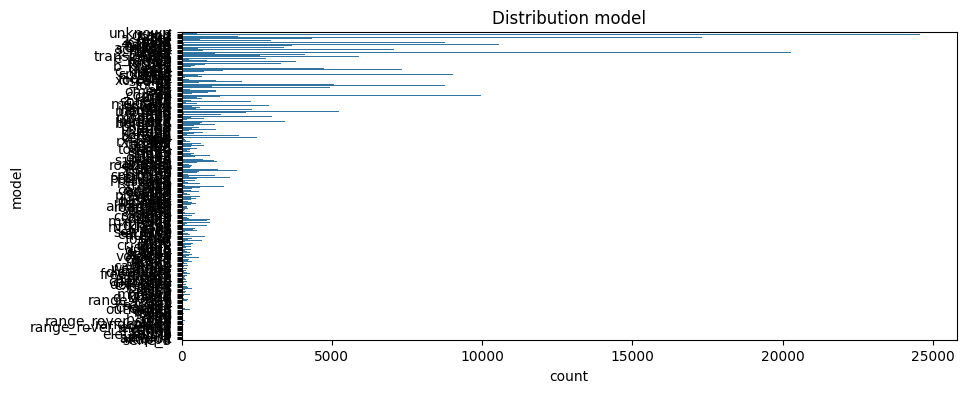

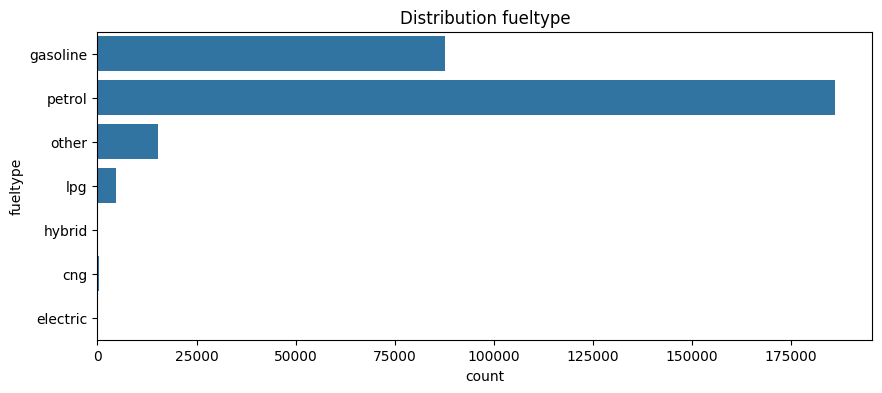

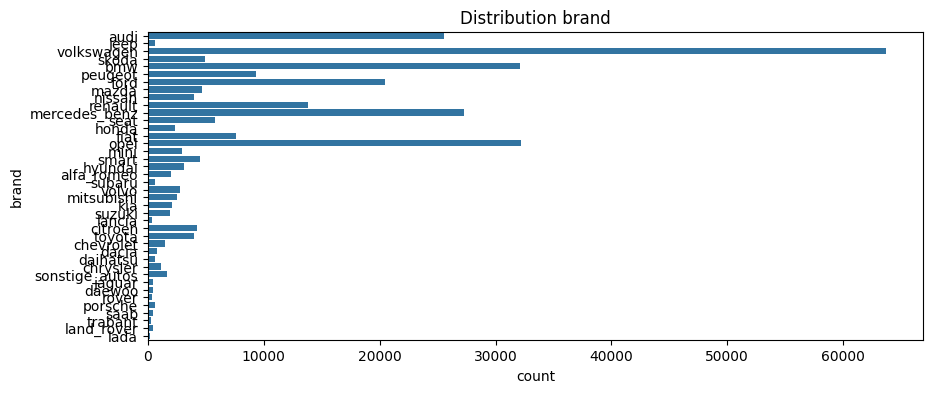

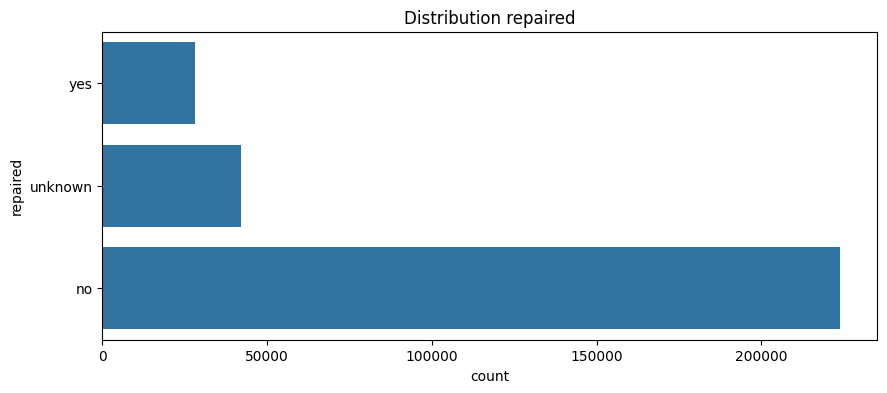

In [26]:
# Defining numeric and categorical columns
numerical_cols = data.select_dtypes(include=['int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Plotting graphs for numeric columns
for col in numerical_cols:
     plt.figure(figsize=(10, 4))
     sns.histplot(data[col], kde=True)
     plt.title(f'Distribution {col}')
     plt.show()

# Plotting categorical columns
for col in categorical_cols:
     plt.figure(figsize=(10, 4))
     sns.countplot(y=data[col])
     plt.title(f'Distribution {col}')
     plt.show()


**Conclusion from the review and data analysis section:**
A review of the data was conducted. 4 obvious duplicates were found and were removed. The columns 'datecrawled', 'datecreated', 'lastseen', 'numberofpictures' were removed as they were not informative for research purposes. There were a lot of missing data in the data, they were replaced with 'other' and 'unknown'. Removed anomalous values in 'registrationyear', 'price', 'power'.

## Model training

In [27]:
RANDOM_STATE=123

In [28]:
# Split data into features (X) and target (y), excluding 'datecrawled'
X = data.drop(['price', 'datecrawled'], axis=1)
y = data['price']

# Define categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object', 'datetime']).columns

# Dividing the data into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Creating a transformer with OneHotEncoder for categorical and StandardScaler for numeric features
column_transformer = ColumnTransformer([
     ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
     ('scaler', StandardScaler(), numerical_cols)
])

# Applying transformation to the training set
X_train= column_transformer.fit_transform(X_train)

# Apply transformation to test sample
X_test= column_transformer.transform(X_test)

In [29]:

# Defining parameters for GridSearchCV
param_grid = {
     'n_estimators': [100], #50 was tested, due to long-term speed the best value was left
     'max_depth': [15] #5,10
}

# Model for selection
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

#GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3,
                            scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Run GridSearchCV
%time grid_search.fit(X_train, y_train)

# Best options
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 24min 11s, sys: 6.28 s, total: 24min 17s
Wall time: 1h 1min 38s
Best parameters: {'max_depth': 15, 'n_estimators': 100}


In [30]:
# Creating a model with the best parameters
best_rf_model = RandomForestRegressor(random_state=RANDOM_STATE, **best_params)

# Model training
%time best_rf_model.fit(X_train, y_train)



CPU times: user 24min, sys: 1.62 s, total: 24min 2s
Wall time: 24min 7s


RandomForestRegressor(max_depth=15, random_state=123)

In [31]:
# Start measuring time for prediction
start_time = time.time()

# Model prediction
rf_predictions = best_rf_model.predict(X_test)

# End of time measurement for prediction
end_time = time.time()

# Output the time spent on prediction
print(f"Time spent making predictions: {end_time - start_time} seconds")

# Model evaluation
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f'RMSE of random forest with best parameters: {rf_rmse}')

Time spent making predictions: 1.199817180633545 seconds
RMSE of random forest with best parameters: 1629.7099946145954


In [32]:
# Search options
param_grid = {
     'n_estimators': [100],
     'max_depth': [10],#5
     'learning_rate': [0.1],#0.01
}

# Model for selection
model = LGBMRegressor(random_state=RANDOM_STATE)

# Grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                            cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
# Getting the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')
best_rmse = np.sqrt(-grid_search.best_score_)
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 235565, number of used features: 301
[LightGBM] [Info] Start training from score 4885.264097
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Best RMSE: 1662.5722295504397


In [33]:
# Creating a model with the best parameters
best_lgb_model = LGBMRegressor(random_state=123, **best_params)

# Measuring model training time
%time best_lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 235565, number of used features: 301
[LightGBM] [Info] Start training from score 4885.264097
CPU times: user 2.51 s, sys: 15 ms, total: 2.52 s
Wall time: 2.52 s


LGBMRegressor(max_depth=10, random_state=123)

In [34]:
# Start measuring time for prediction
start_time = time.time()

# Model prediction
predictions = best_lgb_model.predict(X_test)

# End of time measurement for prediction
end_time = time.time()

# Output the time spent making predictions
print(f"Time spent making predictions: {end_time - start_time} seconds")

# Model evaluation
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE with best parameters: {rmse}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Time spent making predictions: 0.43126988410949707 seconds
RMSE with best parameters: 1654.87992516413


## Model analysis

Based on the presented results, the following conclusions can be drawn for the RandomForestRegressor and LightGBM models trained with optimized parameters:
  

**RandomForestRegressor model:**
Training Time: The training took 18 minutes 51 seconds, which is quite a long time. This indicates the high computational burden associated with training the RandomForestRegressor with the specified parameters.
Prediction Time: The time taken to make predictions was 0.858 seconds, which is relatively fast for the amount of data.
RMSE: The model's RMSE was 1629.71, which indicates a fairly high accuracy of model predictions.
**Model LightGBM:**
Training Time: The model took 27.6 seconds to train, which is significantly faster than RandomForestRegressor. This makes LightGBM a preferred choice in situations where learning speed is important.
Prediction Time: The prediction time was 0.491 seconds, which is even faster than RandomForestRegressor.


RMSE: The model's RMSE was 1654.88, which is slightly higher than RandomForestRegressor, but still shows good prediction accuracy.
# **General conclusion:**

RandomForestRegressor provides higher prediction accuracy (low RMSE) but requires significantly more training time and has a slightly higher prediction time.

LightGBM shows slightly lower accuracy (higher RMSE) but significant learning and prediction speed benefits. This makes it the preferred choice in environments where processing time is critical and where a small loss in accuracy is acceptable.

LightGBM is preferable for these customer requirements